Running Newcomb's Problem...
Running Death in Damascus...
Running Asym. Damascus (Softmax)...
Running Repellor (Softmax)...
Running LARPS...
Running Coordination Game...


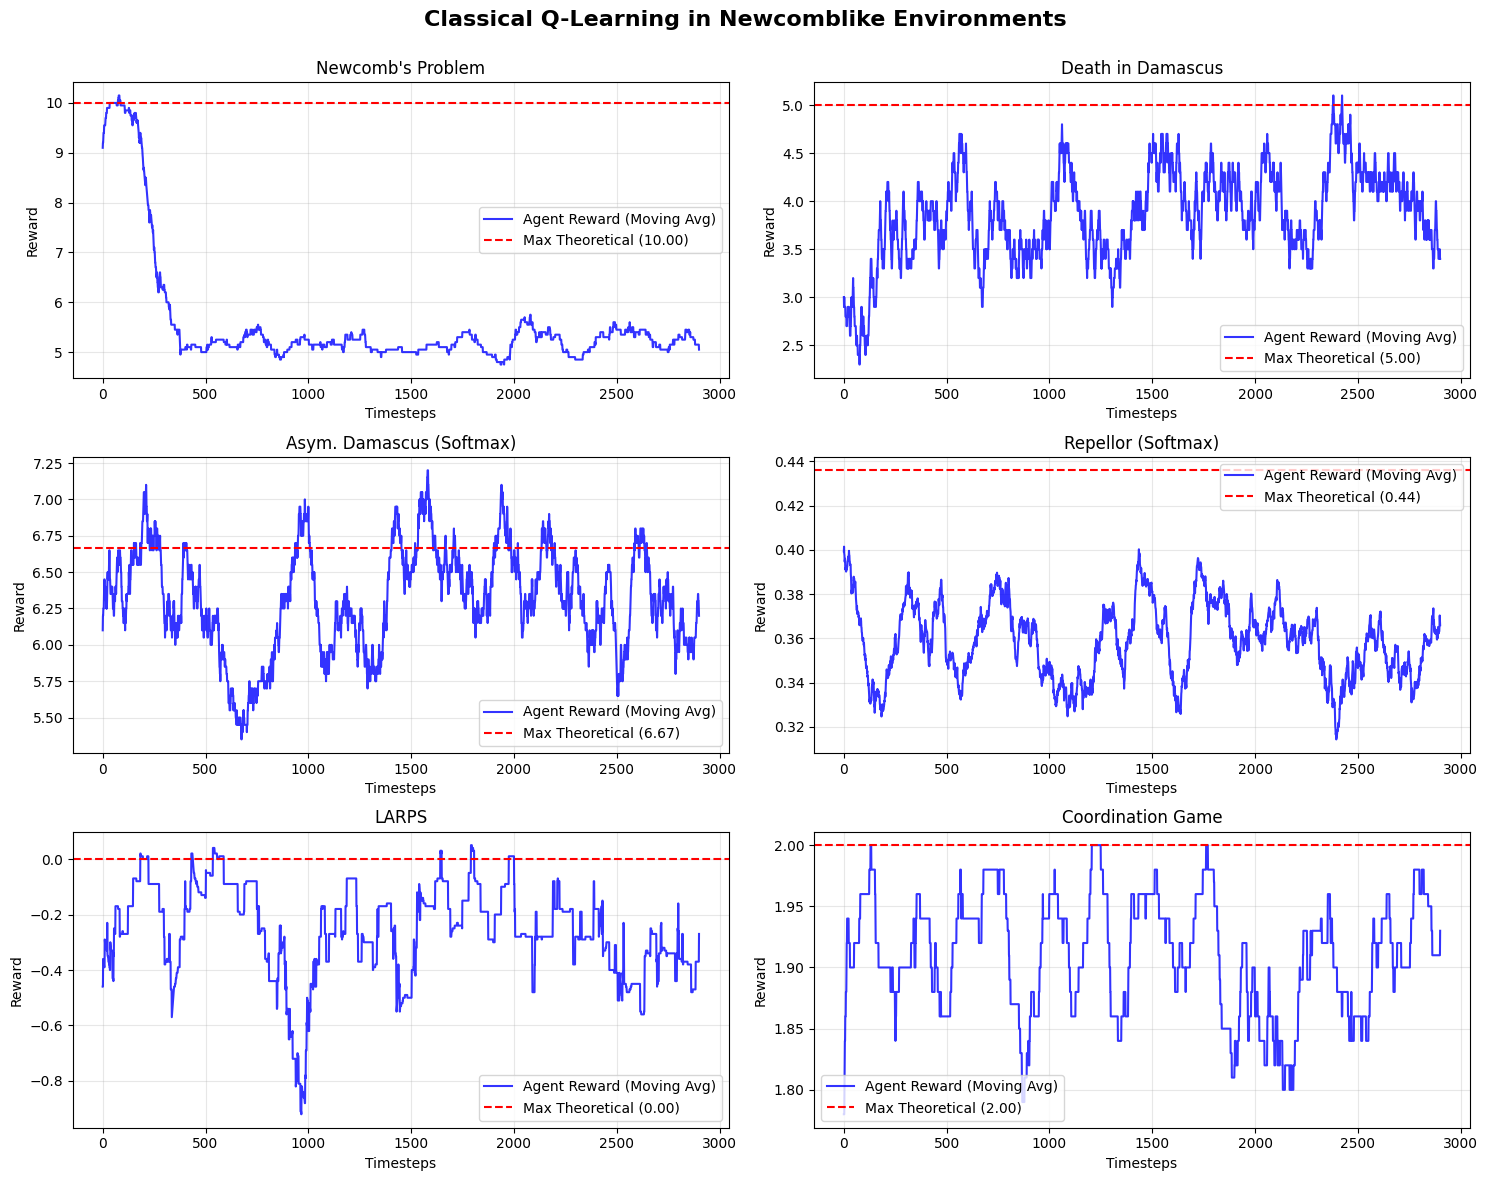

Done! Check the generated plot window.


In [2]:
import math
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt

# =====================================================================
# 1. THE BASE NDP ENVIRONMENT
# =====================================================================
class NewcomblikeEnv(gym.Env):
    def __init__(self, num_actions, alpha_pi=0.05):
        super().__init__()
        self.action_space = spaces.Discrete(num_actions)
        self.observation_space = spaces.Discrete(1)
        self.alpha_pi = alpha_pi
        self.pi_estimate = np.ones(num_actions) / num_actions

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.pi_estimate = np.ones(self.action_space.n) / self.action_space.n
        return 0, {}

    def step(self, action):
        action_vec = np.zeros(self.action_space.n)
        action_vec[action] = 1.0
        self.pi_estimate = (1 - self.alpha_pi) * self.pi_estimate + self.alpha_pi * action_vec
        
        reward = self.sample_reward(action, self.pi_estimate)
        return 0, reward, False, False, {"pi_estimate": self.pi_estimate.copy()}

    def sample_reward(self, action, pi):
        raise NotImplementedError

    def expected_reward(self, action, pi):
        raise NotImplementedError


# =====================================================================
# 2. SPECIFIC ENVIRONMENTS FROM THE PAPER
# =====================================================================
class NewcombsProblemEnv(NewcomblikeEnv):
    """Max Expected Reward: 10.0 (One-Boxing)"""
    def __init__(self): super().__init__(2)
    def sample_reward(self, action, pi):
        predicted_one_box = self.np_random.random() < pi[0]
        if action == 0: return 10.0 if predicted_one_box else 0.0
        else:           return 15.0 if predicted_one_box else 5.0

class DeathInDamascusEnv(NewcomblikeEnv):
    """Max Expected Reward: 5.0 (Mixing 50/50)"""
    def __init__(self): super().__init__(2)
    def sample_reward(self, action, pi):
        predicted_damascus = self.np_random.random() < pi[0]
        if action == 0: return 0.0 if predicted_damascus else 10.0
        else:           return 10.0 if predicted_damascus else 0.0

class AsymmetricDamascusEnv(NewcomblikeEnv):
    """Max Expected Reward: ~6.66 (Mixing 1/3 Damascus, 2/3 Aleppo)"""
    def __init__(self): super().__init__(2)
    def sample_reward(self, action, pi):
        predicted_damascus = self.np_random.random() < pi[0]
        if action == 0: return 0.0 if predicted_damascus else 10.0
        else:           return 10.0 if predicted_damascus else 5.0

class LARPSEnv(NewcomblikeEnv):
    """Max Expected Reward: 0.0 (Mixing 1/3, 1/3, 1/3)"""
    def __init__(self):
        super().__init__(3)
        self.payoffs = np.array([[0, -10, 1], [1, 0, -10], [-10, 1, 0]])
    def sample_reward(self, action, pi):
        opponent_action = self.np_random.choice(3, p=pi/np.sum(pi))
        return float(self.payoffs[action, opponent_action])

class CoordinationEnv(NewcomblikeEnv):
    """Max Expected Reward: 2.0 (Always Action 0)"""
    def __init__(self):
        super().__init__(2)
        self.payoffs = np.array([[2, 0], [0, 1]])
    def sample_reward(self, action, pi):
        opponent_action = self.np_random.choice(2, p=pi/np.sum(pi))
        return float(self.payoffs[action, opponent_action])

class RepellorEnv(NewcomblikeEnv):
    """Max Expected Reward: ~0.436 (Mixing 1/3, 1/3, 1/3)"""
    def __init__(self): super().__init__(3)
    def sample_reward(self, action, pi):
        # E[R(a_i, pi)] = pi(a_{i+1}) + 532 * pi(a_i) * [all pi >= 0.25] * Prod(pi - 0.25)
        next_action = (action + 1) % 3
        term1 = pi[next_action]
        
        if all(p >= 0.25 for p in pi):
            prod_term = math.prod(p - 0.25 for p in pi)
            term2 = 4 * 133 * pi[action] * prod_term
        else:
            term2 = 0.0
            
        expected_r = term1 + term2
        # Return expected reward + some noise (the paper notes rewards are stochastic)
        return expected_r + self.np_random.normal(0, 0.1)


# =====================================================================
# 3. BASELINE AGENT
# =====================================================================
class QLearningAgent:
    def __init__(self, num_actions, policy_type='egreedy', alpha=0.1):
        self.num_actions = num_actions
        self.policy_type = policy_type
        self.alpha = alpha
        self.Q = np.zeros(num_actions)
        self.t = 1

    def act(self):
        if self.policy_type == 'egreedy':
            epsilon = 0.05
            if np.random.random() < epsilon:
                return np.random.randint(self.num_actions)
            return np.argmax(self.Q)
            
        elif self.policy_type == 'softmax':
            # Temperature cooling schedule: tau decays slowly
            tau = max(0.1, 5.0 / (self.t ** 0.3))
            # Numerically stable softmax
            q_shifted = self.Q - np.max(self.Q)
            exp_q = np.exp(q_shifted / tau)
            probs = exp_q / np.sum(exp_q)
            return np.random.choice(self.num_actions, p=probs)

    def update(self, action, reward):
        self.Q[action] = (1 - self.alpha) * self.Q[action] + self.alpha * reward
        self.t += 1


# =====================================================================
# 4. EXPERIMENT RUNNER & PLOTTER
# =====================================================================
def run_experiment(env_class, policy_type, max_reward, steps=3000):
    env = env_class()
    agent = QLearningAgent(num_actions=env.action_space.n, policy_type=policy_type)
    env.reset()
    
    rewards = []
    for _ in range(steps):
        action = agent.act()
        _, reward, _, _, _ = env.step(action)
        agent.update(action, reward)
        rewards.append(reward)
        
    # Calculate moving average for clean plotting
    window = 100
    moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
    return moving_avg, max_reward

if __name__ == "__main__":
    experiments = [
        ("Newcomb's Problem", NewcombsProblemEnv, 'egreedy', 10.0),
        ("Death in Damascus", DeathInDamascusEnv, 'egreedy', 5.0),
        ("Asym. Damascus (Softmax)", AsymmetricDamascusEnv, 'softmax', 6.666),
        ("Repellor (Softmax)", RepellorEnv, 'softmax', 0.436),
        ("LARPS", LARPSEnv, 'egreedy', 0.0),
        ("Coordination Game", CoordinationEnv, 'egreedy', 2.0)
    ]

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle("Classical Q-Learning in Newcomblike Environments", fontsize=16, fontweight='bold')
    axes = axes.flatten()

    for idx, (name, env_class, pol_type, max_r) in enumerate(experiments):
        print(f"Running {name}...")
        moving_avg, theoretical_max = run_experiment(env_class, pol_type, max_r)
        
        ax = axes[idx]
        ax.plot(moving_avg, label="Agent Reward (Moving Avg)", color='blue', alpha=0.8)
        
        if theoretical_max is not None:
            ax.axhline(y=theoretical_max, color='red', linestyle='--', 
                       label=f"Max Theoretical ({theoretical_max:.2f})")
            
        ax.set_title(name)
        ax.set_xlabel("Timesteps")
        ax.set_ylabel("Reward")
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    print("Done! Check the generated plot window.")